# Pneumonia Classification and Detection


## Small explanation




### Imports

In [223]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import io
from skimage import measure
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder  


import torch
import torchvision
import torchvision.transforms as transforms

import pandas as pd

import warnings
warnings.filterwarnings('ignore')

### Data Load

Data is composed by the X-ray image, a label including the id and the position of the anomalies (if there is one) and finally a class {Pneumonia, Normal, Not pneumonia and Not normal}.

Since the dataset is too much to store in memory, it will need to be loaded on batched during the training process. 
Hence a loader is needed. 

In [224]:
DATA_PATH="./rsna-pneumonia-detection-challenge"

labels_frame = pd.read_csv(DATA_PATH + '/stage_2_train_labels.csv')

detailed_class_info = pd.read_csv(DATA_PATH + '/stage_2_detailed_class_info.csv')

total_images_size = len(detailed_class_info)

train_images_size = int(.8*total_images_size)

train_classes = detailed_class_info.iloc[:train_images_size,:]

train_data = labels_frame.iloc[:train_images_size,:]
train_data['class'] = train_classes['class'].values  

print(train_data.iloc[4,:])
print(train_data.iloc[5,:])

patientId    00436515-870c-4b36-a041-de91049b9ab4
x                                             264
y                                             152
width                                         213
height                                        379
Target                                          1
class                                Lung Opacity
Name: 4, dtype: object
patientId    00436515-870c-4b36-a041-de91049b9ab4
x                                             562
y                                             152
width                                         256
height                                        453
Target                                          1
class                                Lung Opacity
Name: 5, dtype: object


In [225]:
class data_loader: 
    pass
    

def load_scan(path,image_name):
    img = dicom.read_file(path + '/' + image_name,force=True).pixel_array
    return image

### Exploring Data 

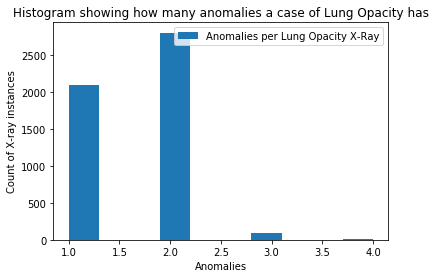

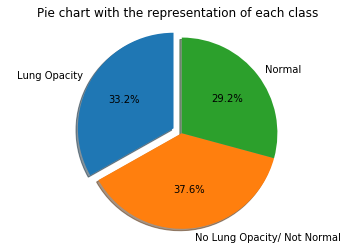

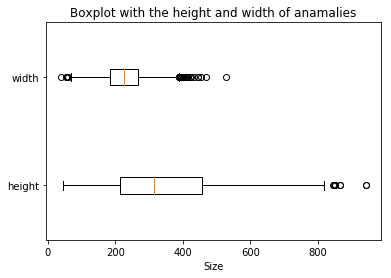

In [243]:
x = train_data.loc[train_data['class'] == 'Lung Opacity'][['patientId','class']].groupby(['patientId','class']).size()


plt.hist(x,label='Anomalies per Lung Opacity X-Ray')
plt.legend()
plt.title('Histogram showing how many anomalies a case of Lung Opacity has')
plt.ylabel('Count of X-ray instances')
plt.xlabel('Anomalies')

plt.show()

x = train_data[['patientId','class']].groupby('class').size()

plt.pie(x,labels= ["Lung Opacity","No Lung Opacity/ Not Normal","Normal"],autopct='%1.1f%%',explode=( 0.1, 0, 0),shadow=True, startangle=90 )
plt.title('Pie chart with the representation of each class')
plt.axis('equal')
plt.show()



plt.boxplot([train_data.loc[train_data['class'] == 'Lung Opacity'].height,train_data.loc[train_data['class'] == 'Lung Opacity'].width],vert=False,labels=["height","width"])
plt.title('Boxplot with the height and width of anamalies')
plt.xlabel('Size')
plt.show()


00704310-78a8-4b38-8475-49f4573b2dbb
[[ 60  49  39 ...   2   1   0]
 [ 60  49  39 ...   2   1   0]
 [ 59  49  39 ...   2   1   0]
 ...
 [ 96  92  86 ...  41  40  24]
 [108 104  97 ...  46  45  28]
 [119 115 109 ...  52  52  34]]


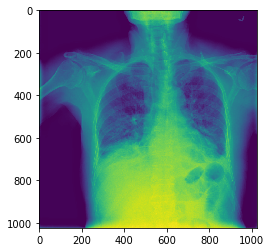

In [227]:
img_name = labels_frame.iloc[8, 0]
print(img_name)
labels = labels_frame.iloc[8, 1:5].as_matrix()
labels = labels.astype('float').reshape(-1, 2).T

image = load_scan(DATA_PATH + "/stage_2_train_images",img_name + ".dcm")
print(image)
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    #plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    #plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_landmarks(image,labels)
plt.show()


### Training, Validation and Test Set division

### Data preprocessing

### Model

### Training

### Performance Results